<a href="https://colab.research.google.com/github/gelgel5633/personal_project/blob/main/%EB%8D%B0%EC%9D%B4%EC%BD%98_%EC%9E%90%EC%9C%A8%EC%A3%BC%ED%96%89_%EC%84%BC%EC%84%9C%EC%9D%98_%EC%95%88%ED%85%8C%EB%82%98_%EC%84%B1%EB%8A%A5_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 목적 : 변수 분석을 통한 안테나의 성능 예측
## 가설
- 비슷한 공정의 경우 (예 : 스크류 삽입 깊이 1,2,3,4....) 상관성이 높을 것이므로 한 공정을 제외한 나머지 공정을 제거해도 문제가 되지 않을 것이다
- 특정 columns를 제거할 때 예측에서 가장 영향을 많이 끼치는 것은 맨 처음 공정일 것이다(=제일 처음 공정을 제외하면 나머지는 큰 차이를 보이지 않을 것이다)


# import

In [ ]:
import pandas as pd
import random
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# data load

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/dacon/lg_antena/train.csv")

In [ ]:
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

In [ ]:
X_train = train_x.copy()
Y_train = train_y.copy()

In [ ]:
test_x = pd.read_csv('/content/drive/MyDrive/dacon/lg_antena/test.csv').drop(columns=['ID'])

In [ ]:
X_train.head(3)

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,0.0,...,1,1,9706.03,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,0.0,...,1,1,10423.43,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,0.0,...,1,1,10948.53,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232


In [ ]:
X_train.shape

(39607, 56)

In [ ]:
X_train.isnull().sum()

X_01    0
X_02    0
X_03    0
X_04    0
X_05    0
X_06    0
X_07    0
X_08    0
X_09    0
X_10    0
X_11    0
X_12    0
X_13    0
X_14    0
X_15    0
X_16    0
X_17    0
X_18    0
X_19    0
X_20    0
X_21    0
X_22    0
X_23    0
X_24    0
X_25    0
X_26    0
X_27    0
X_28    0
X_29    0
X_30    0
X_31    0
X_32    0
X_33    0
X_34    0
X_35    0
X_36    0
X_37    0
X_38    0
X_39    0
X_40    0
X_41    0
X_42    0
X_43    0
X_44    0
X_45    0
X_46    0
X_47    0
X_48    0
X_49    0
X_50    0
X_51    0
X_52    0
X_53    0
X_54    0
X_55    0
X_56    0
dtype: int64

결측치가 존재하지 않음

In [ ]:
print(X_train["X_04"].value_counts())
print("-------------")
print(X_train["X_23"].value_counts())
print("-------------")
print(X_train["X_47"].value_counts())
print("-------------")
print(X_train["X_48"].value_counts())

1    39607
Name: X_04, dtype: int64
-------------
1    39607
Name: X_23, dtype: int64
-------------
1    39607
Name: X_47, dtype: int64
-------------
1    39607
Name: X_48, dtype: int64


위의 항목을 실행해보았을 때 X_04 X_23 X_47 X_48은 한 가지의 값만 나오므로 필요없는 columns가 되므로 삭제
- 공통적으로 "x차 검사 통과 여부" 항목
- 앞으로 분석은 관련있는 항목끼리 진행

In [ ]:
X_train.drop(["X_04", "X_23", "X_47", "X_48"], axis = 1, inplace = True)

In [ ]:
test_x.drop(["X_04", "X_23", "X_47", "X_48"], axis = 1, inplace = True)

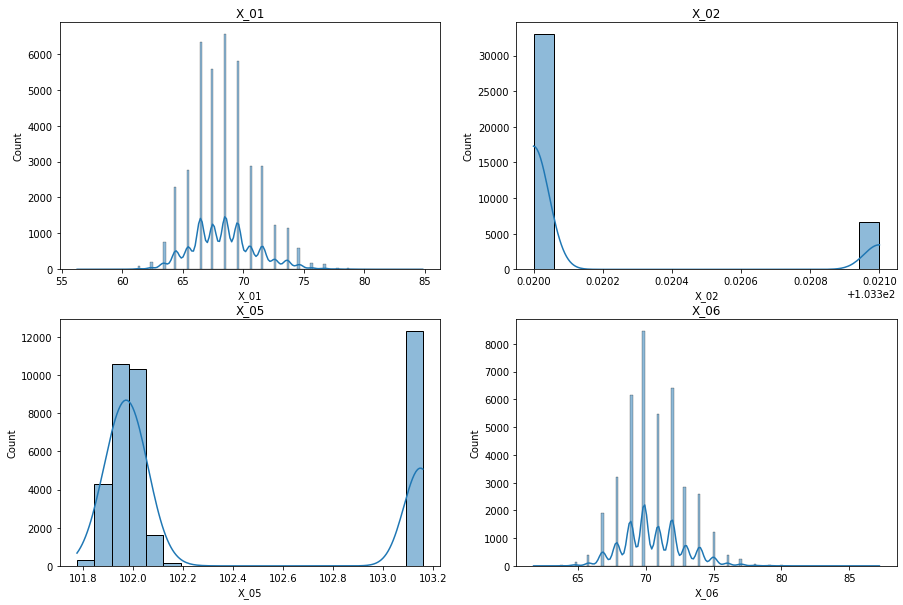

In [ ]:
# https://dacon.io/competitions/official/235927/codeshare/6042?page=1&dtype=recent 코드 참조
# PCB 체결 시 단계별 누름량 -> 01, 02, 05, 06에 대한 분포 확인
pcb = X_train[['X_01','X_02','X_05','X_06']]

fig, axes = plt.subplots(2,2, figsize = (15,10))

sns.histplot(data = pcb, x = "X_01", kde = True, ax = axes[0,0]).set(title = "X_01")
sns.histplot(data = pcb, x = "X_02", kde = True, ax = axes[0,1]).set(title = "X_02")
sns.histplot(data = pcb, x = "X_05", kde = True, ax = axes[1,0]).set(title = "X_05")
sns.histplot(data = pcb, x = "X_06", kde = True, ax = axes[1,1]).set(title = "X_06")

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

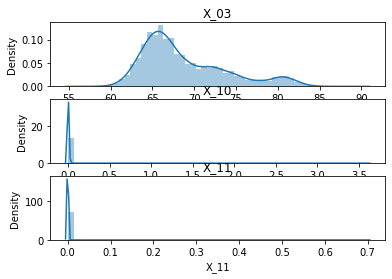

In [ ]:
# 방열재료 무게 x
fig = plt.figure()

ax1 = fig.add_subplot(311)
sns.distplot(X_train["X_03"])
ax1.set_title('X_03')

ax2 = fig.add_subplot(312)
sns.distplot(X_train["X_10"])
ax2.set_title('X_10')

ax3 = fig.add_subplot(3,1,3)
sns.distplot(X_train["X_11"])
ax3.set_title('X_11')

plt.show()

- X_10, X_11이 매우 좁은 분포로 나타남 -> 확인 필요

In [ ]:
print(X_train["X_10"].value_counts())
print(X_train["X_11"].value_counts())

0.0    39575
2.9       12
3.0       12
3.3        4
3.1        2
3.6        1
3.2        1
Name: X_10, dtype: int64
0.0    39580
0.5       12
0.6       11
0.4        3
0.7        1
Name: X_11, dtype: int64


In [ ]:
print(len(X_train[X_train["X_10"]>=0.1]) / len(X_train[X_train["X_10"]==0]))
print(len(X_train[X_train["X_11"]>=0.1]) / len(X_train[X_train["X_11"]==0]))

0.0008085912823752369
0.0006821627084386054


- 방열재료 무게 2,3인 X_10, X_11에서 0.0 이외의 값으로 나타난 값은 매우 적은 수 이므로 특별한 학습이 불가능할 것으로 판단되어 삭제

In [ ]:
X_train.drop(["X_10", "X_11"], axis = 1, inplace = True)

In [ ]:
test_x.drop(["X_10", "X_11"], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

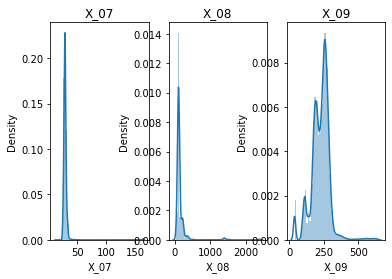

In [ ]:
# X_07 ~ 09 방열 재료 면적
fig = plt.figure()

ax1 = fig.add_subplot(131)
sns.distplot(X_train["X_07"])
ax1.set_title('X_07')

ax2 = fig.add_subplot(132)
sns.distplot(X_train["X_08"])
ax2.set_title('X_08')

ax3 = fig.add_subplot(133)
sns.distplot(X_train["X_09"])
ax3.set_title('X_09')

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


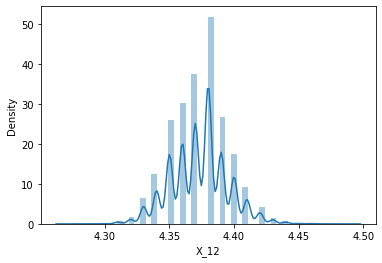

In [ ]:
# X_12 커넥터 위치 기준 좌표
sns.distplot(X_train["X_12"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


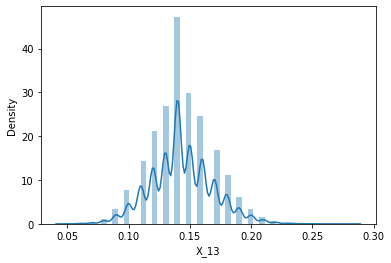

In [ ]:
# X_13,각 안테나 패드 위치(높이) 차이
sns.distplot(X_train["X_13"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_18')

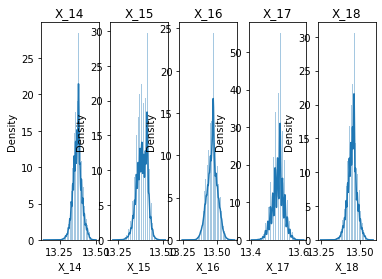

In [ ]:
# X_14 ~ 18 x번 안테나 패드 위치
fig = plt.figure()

ax1 = fig.add_subplot(151)
sns.distplot(X_train["X_14"])
ax1.set_title('X_14')

ax2 = fig.add_subplot(152)
sns.distplot(X_train["X_15"])
ax2.set_title('X_15')

ax3 = fig.add_subplot(153)
sns.distplot(X_train["X_16"])
ax3.set_title('X_16')

ax4 = fig.add_subplot(154)
sns.distplot(X_train["X_17"])
ax4.set_title('X_17')

ax5 = fig.add_subplot(155)
sns.distplot(X_train["X_18"])
ax5.set_title('X_18')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_22')

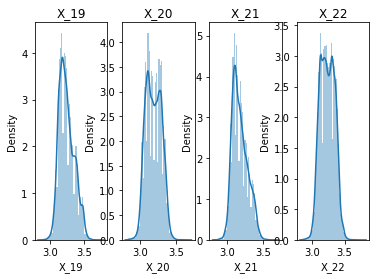

In [ ]:
# X19 ~ 22 
fig = plt.figure()

ax1 = fig.add_subplot(141)
sns.distplot(X_train["X_19"])
ax1.set_title('X_19')

ax2 = fig.add_subplot(142)
sns.distplot(X_train["X_20"])
ax2.set_title('X_20')

ax3 = fig.add_subplot(143)
sns.distplot(X_train["X_21"])
ax3.set_title('X_21')

ax4 = fig.add_subplot(144)
sns.distplot(X_train["X_22"])
ax4.set_title('X_22')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_29')

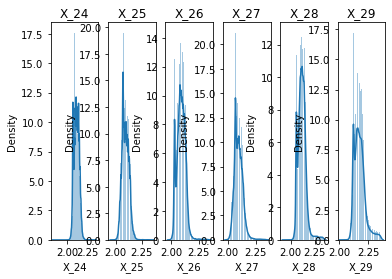

In [ ]:
# X24 ~ 29 커넥터 x번 핀 치수

fig = plt.figure()

ax1 = fig.add_subplot(161)
sns.distplot(X_train["X_24"])
ax1.set_title('X_24')

ax2 = fig.add_subplot(162)
sns.distplot(X_train["X_25"])
ax2.set_title('X_25')

ax3 = fig.add_subplot(163)
sns.distplot(X_train["X_26"])
ax3.set_title('X_26')

ax4 = fig.add_subplot(164)
sns.distplot(X_train["X_27"])
ax4.set_title('X_27')

ax5 = fig.add_subplot(165)
sns.distplot(X_train["X_28"])
ax5.set_title('X_28')

ax6 = fig.add_subplot(166)
sns.distplot(X_train["X_29"])
ax6.set_title('X_29')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_33')

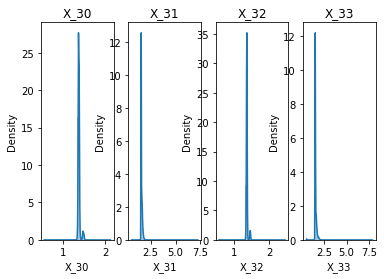

In [ ]:
# X_30 ~ 33 스크류 삽입 깊이 x

fig = plt.figure()

ax1 = fig.add_subplot(141)
sns.distplot(X_train["X_30"])
ax1.set_title('X_30')

ax2 = fig.add_subplot(142)
sns.distplot(X_train["X_31"])
ax2.set_title('X_31')

ax3 = fig.add_subplot(143)
sns.distplot(X_train["X_32"])
ax3.set_title('X_32')

ax4 = fig.add_subplot(144)
sns.distplot(X_train["X_33"])
ax4.set_title('X_33')

In [ ]:
X_train["X_30"].value_counts(sort=True)

1.37    11784
1.38    10830
1.36     5976
1.39     5091
1.35     1975
1.40     1390
1.48      485
1.49      389
1.47      386
1.34      291
1.41      270
1.50      254
1.46      184
1.51       69
1.45       53
1.42       45
1.33       32
1.52       24
1.44       17
0.57       12
1.43        9
1.32        8
1.31        7
1.28        4
1.30        3
1.53        3
1.27        2
1.55        2
1.60        2
1.57        2
1.29        2
1.54        1
2.03        1
1.99        1
1.78        1
2.11        1
1.62        1
Name: X_30, dtype: int64

In [ ]:
X_train["X_31"].value_counts()

1.54    6107
1.53    5851
1.52    4594
1.55    4092
1.56    2677
        ... 
2.09       1
2.04       1
2.05       1
2.08       1
2.01       1
Name: X_31, Length: 77, dtype: int64

In [ ]:
X_train["X_32"].value_counts(sort=True)

1.36    13644
1.35    10773
1.37     8156
1.34     2885
1.38     1686
1.46      664
1.47      478
1.45      386
1.33      351
1.39      180
1.44      138
1.48       92
1.32       47
1.43       34
1.40       23
0.57       16
1.49        9
1.42        9
1.41        6
1.31        6
1.29        3
1.27        2
1.52        2
1.30        2
1.28        2
1.68        1
1.92        1
2.45        1
1.26        1
1.55        1
1.59        1
1.54        1
1.90        1
1.56        1
2.11        1
1.84        1
1.96        1
1.67        1
Name: X_32, dtype: int64

In [ ]:
X_train["X_33"].value_counts(sort=True)

1.55    5908
1.56    5448
1.57    4425
1.54    3908
1.58    3133
        ... 
2.66       1
2.33       1
2.24       1
2.31       1
7.81       1
Name: X_33, Length: 94, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_37')

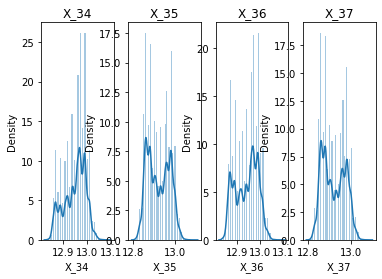

In [ ]:
# X_34 ~ 37 스크류 체결 시 분당 회전수 x
fig = plt.figure()

ax1 = fig.add_subplot(141)
sns.distplot(X_train["X_34"])
ax1.set_title('X_34')

ax2 = fig.add_subplot(142)
sns.distplot(X_train["X_35"])
ax2.set_title('X_35')

ax3 = fig.add_subplot(143)
sns.distplot(X_train["X_36"])
ax3.set_title('X_36')

ax4 = fig.add_subplot(144)
sns.distplot(X_train["X_37"])
ax4.set_title('X_37')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_40')

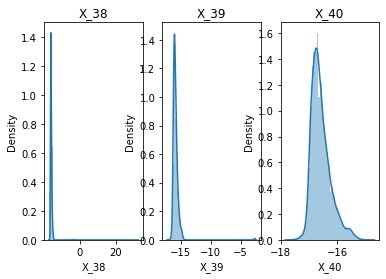

In [ ]:
# X_38 ~ 40 하우징 PCB 안착부 x 치수
fig = plt.figure()

ax1 = fig.add_subplot(131)
sns.distplot(X_train["X_38"])
ax1.set_title('X_38')

ax2 = fig.add_subplot(132)
sns.distplot(X_train["X_39"])
ax2.set_title('X_39')

ax3 = fig.add_subplot(133)
sns.distplot(X_train["X_40"])
ax3.set_title('X_40')

In [ ]:
X_train["X_38"].value_counts()

-16.11    733
-16.02    711
-16.04    702
-16.08    702
-16.13    701
         ... 
-17.04      1
-14.51      1
-14.12      1
-16.84      1
-17.02      1
Name: X_38, Length: 253, dtype: int64

In [ ]:
X_train["X_39"].value_counts()

-16.08    750
-16.11    743
-15.99    692
-16.02    689
-16.13    687
         ... 
-17.09      1
-14.16      1
-14.33      1
-16.82      1
-16.97      1
Name: X_39, Length: 252, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'X_44')

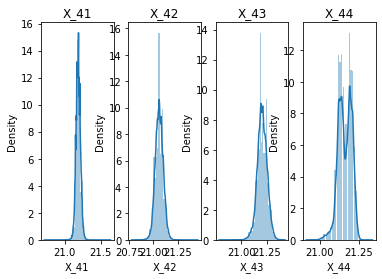

In [ ]:
# X_41 ~ 44 레이돔 치수 (안테나 x번 부위)
fig = plt.figure()

ax1 = fig.add_subplot(141)
sns.distplot(X_train["X_41"])
ax1.set_title('X_41')

ax2 = fig.add_subplot(142)
sns.distplot(X_train["X_42"])
ax2.set_title('X_42')

ax3 = fig.add_subplot(143)
sns.distplot(X_train["X_43"])
ax3.set_title('X_43')

ax4 = fig.add_subplot(144)
sns.distplot(X_train["X_44"])
ax4.set_title('X_44')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


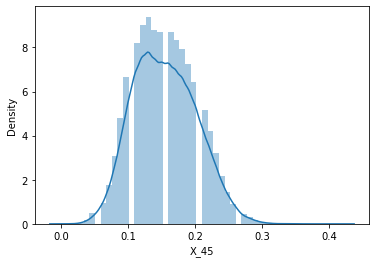

In [ ]:
# X_45,안테나 부분 레이돔 기울기
sns.distplot(X_train["X_45"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


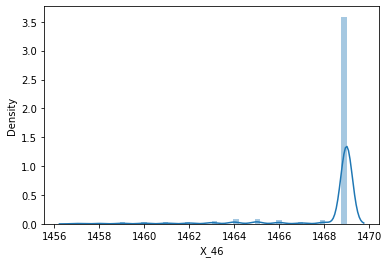

In [ ]:
# X_46,실란트 본드 소요량
sns.distplot(X_train["X_46"])

In [ ]:
X_train["X_46"].value_counts()

1469    34088
1465      881
1464      780
1468      696
1466      610
1463      549
1467      389
1462      365
1461      308
1460      305
1459      259
1458      197
1457      180
Name: X_46, dtype: int64

In [ ]:
len(X_train[X_train["X_46"]==1469]) /len(X_train["X_46"])

0.8606559446562476

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


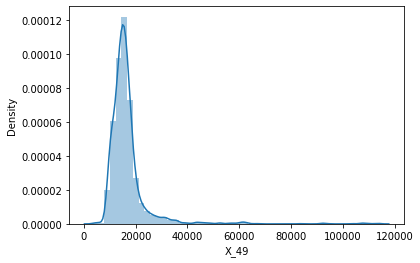

In [ ]:
# X_49,Cal 투입 전 대기 시간
sns.distplot(X_train["X_49"])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

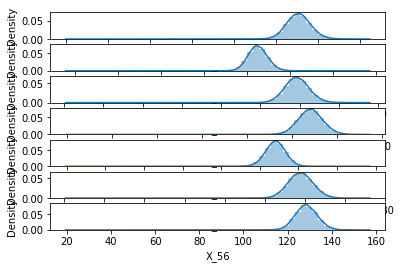

In [ ]:
# X_50 ~ 56 RF x 부분 SMT 납 량
fig = plt.figure()

SMT_list = ["X_50", "X_51", "X_52", "X_53", "X_54", "X_55", "X_56"]

for i, j in enumerate(SMT_list):
    ax = fig.add_subplot(7,1,i+1)
    sns.distplot(X_train["{}".format(j)])

In [ ]:
len(X_train.columns)

50

- 편향 존재 : 2, 5, 7, 8, 30, 31, 32, 33, 38, 39, 46, 49 -> 일괄 로그 변환

- 문제점 : X_38, X_39는 데이터가 음수값이기 때문에 log를 취해주면 결측치가 되어버리므로 이 두 값은 제외하고 나머지 값들만 로그변환

In [ ]:
X_train[["X_02", "X_05", "X_07", "X_08", "X_30", "X_31", "X_32", "X_33", "X_46", "X_49"]] = \
X_train[["X_02", "X_05", "X_07", "X_08", "X_30", "X_31", "X_32", "X_33", "X_46", "X_49"]].apply(lambda x : np.log1p(x))

In [ ]:
test_x[["X_02", "X_05", "X_07", "X_08", "X_30", "X_31", "X_32", "X_33", "X_46", "X_49"]] = \
test_x[["X_02", "X_05", "X_07", "X_08", "X_30", "X_31", "X_32", "X_33", "X_46", "X_49"]].apply(lambda x : np.log1p(x))

In [ ]:
X_train.isnull().sum()

X_01    0
X_02    0
X_03    0
X_05    0
X_06    0
X_07    0
X_08    0
X_09    0
X_12    0
X_13    0
X_14    0
X_15    0
X_16    0
X_17    0
X_18    0
X_19    0
X_20    0
X_21    0
X_22    0
X_24    0
X_25    0
X_26    0
X_27    0
X_28    0
X_29    0
X_30    0
X_31    0
X_32    0
X_33    0
X_34    0
X_35    0
X_36    0
X_37    0
X_38    0
X_39    0
X_40    0
X_41    0
X_42    0
X_43    0
X_44    0
X_45    0
X_46    0
X_49    0
X_50    0
X_51    0
X_52    0
X_53    0
X_54    0
X_55    0
X_56    0
dtype: int64

In [ ]:
test_x.isnull().sum()

X_01    0
X_02    0
X_03    0
X_05    0
X_06    0
X_07    0
X_08    0
X_09    0
X_12    0
X_13    0
X_14    0
X_15    0
X_16    0
X_17    0
X_18    0
X_19    0
X_20    0
X_21    0
X_22    0
X_24    0
X_25    0
X_26    0
X_27    0
X_28    0
X_29    0
X_30    0
X_31    0
X_32    0
X_33    0
X_34    0
X_35    0
X_36    0
X_37    0
X_38    0
X_39    0
X_40    0
X_41    0
X_42    0
X_43    0
X_44    0
X_45    0
X_46    0
X_49    0
X_50    0
X_51    0
X_52    0
X_53    0
X_54    0
X_55    0
X_56    0
dtype: int64

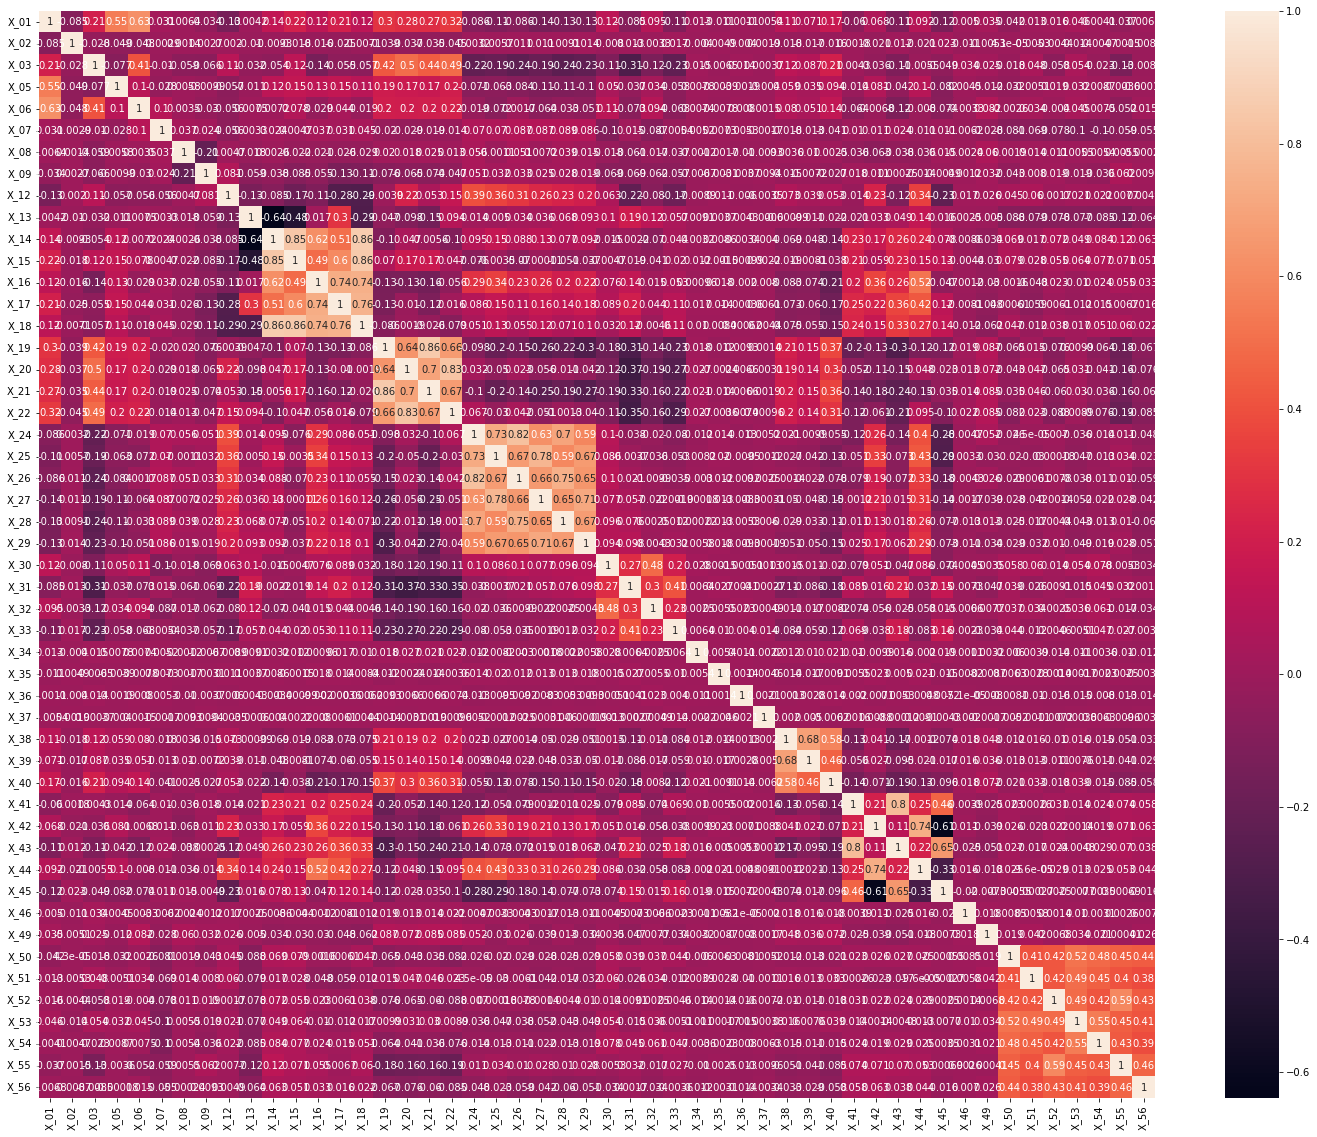

In [ ]:
plt.figure(figsize = (25,20))
sns.heatmap(X_train.corr(), annot = True)

- 14,15,16,17,18 -> x번 안테나 패드 위치에서 매우 강한 상관관계 발생. 14번을 제외한 나머지 제거
- 19, 20, 21, 22 -> x번 스크류 삽입 깊이 또한 강한 상관관계. 19번 제외 나머지 제거
- 24, 25, 26, 27, 28, 29 -> 커넥터 x번 핀 치수 강한 상관관계. 24번 제외 나머지 제거
- 38, 39, 40 -> 하우징 PCB 안착부 x 치수 강한 상관관계. 38번 제외 나머지 제거
- 50, 51, 52, 53, 54, 55, 56 -> RF x 부분 SMT 납 량 강한 상관관계. 50번 제외 나머지 제거
- 제거 제외 기준 : 해당 단계에서의 처음 공정
---
=> 15,16,17,18,20,21,22,25,26,27,28,29,39,40,51,52,53,54,55,56 번 제거

In [ ]:
X_train.drop(["X_15", "X_16","X_17","X_18","X_20","X_21","X_22","X_25","X_26","X_27","X_28","X_29","X_39","X_40","X_51","X_52","X_53","X_54", "X_55","X_56"], axis = 1, inplace = True)
test_x.drop(["X_15", "X_16","X_17","X_18","X_20","X_21","X_22","X_25","X_26","X_27","X_28","X_29","X_39","X_40","X_51","X_52","X_53","X_54", "X_55","X_56"], axis = 1, inplace = True)

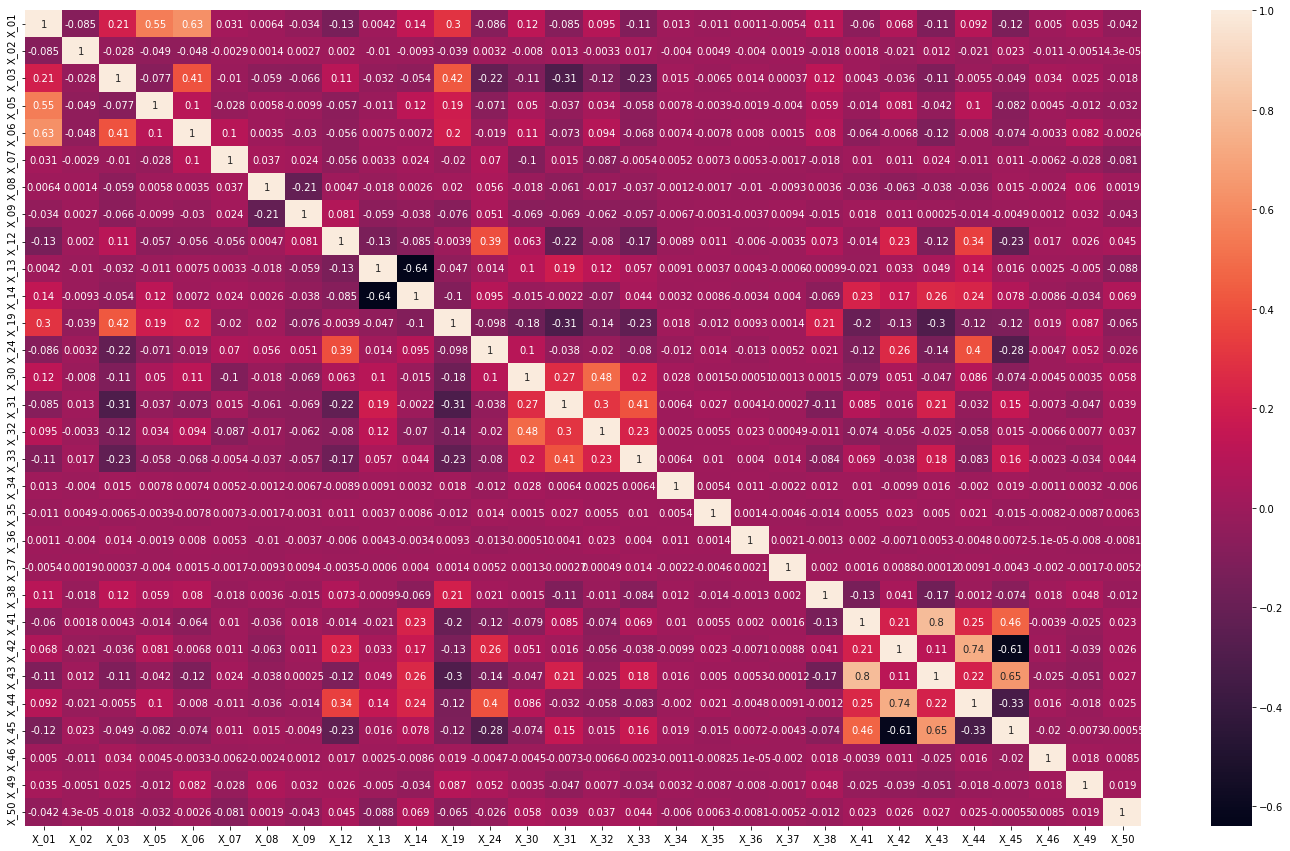

In [ ]:
plt.figure(figsize = (25,15))
sns.heatmap(X_train.corr(), annot = True)

- 13,14 -> 각 안테나 패드 위치, 1번 안테나 패드 위치 강한 음의 상관관계
-> 패드 위치인 13을 남기고 14를 제거
-> 14를 제거해서 x번 안테나 패드 위치는 제거 되어서 더이상 사용할 수 없음
- 42,45 -> 레이돔 치수(안테나 2), 안테나 부분 레이돔 기울기 강한 음의 상관관계
-> 45 레이돔 기울기를 놔두고 42 레이돔 치수 제거
--- 
- 1,6 -> PCB 체결 시 단계별 누름량(Step 1)  PCB 체결 시 단계별 누름량(Step 4) 강한 양의 상관관계
- 1,5 -> PCB 체결 시 단계별 누름량(Step 1) PCB 체결 시 단계별 누름량(Step 3) 강한 양의 상관관계\
-> 5,6 간의 상관관계는 크지 않으므로 1번 제거
---
- 41, 43 -> 레이돔 치수 (안테나 1번 부위) 레이돔 치수 (안테나 3번 부위) 양의 상관관계
- 42, 44 -> 레이돔 치수 (안테나 2번 부위) 레이돔 치수 (안테나 4번 부위) 양의 상관관계
-> 41, 42 남기고 43,44 제거
---
- 30, 32 -> 스크류 삽입 깊이1 스크류 삽입 깊이3 양의 상관관계
- 31, 33 -> 스크류 삽입 깊이2 스크류 삽입 깊이4 양의 상관관계
-> 30, 31남기고 32, 33 제거
---
- 41, 45 -> 레이돔 치수 (안테나 1번 부위) 안테나 부분 레이돔 기울기
-> 41 제거, 45 남김
---
- 3, 19 -> 방열 재료 1 무게 1번 스크류 삽입 깊이
-> 재료보다는 스크류 삽입에따른 차이가 발생할 것이라 판단. 3 제거, 19 남김

In [ ]:
X_train.drop(["X_14","X_42", "X_01", "X_43", "X_44", "X_32", "X_33", "X_41", "X_03"], axis = 1, inplace = True)
test_x.drop(["X_14","X_42", "X_01", "X_43", "X_44", "X_32", "X_33", "X_41", "X_03"], axis = 1, inplace = True)

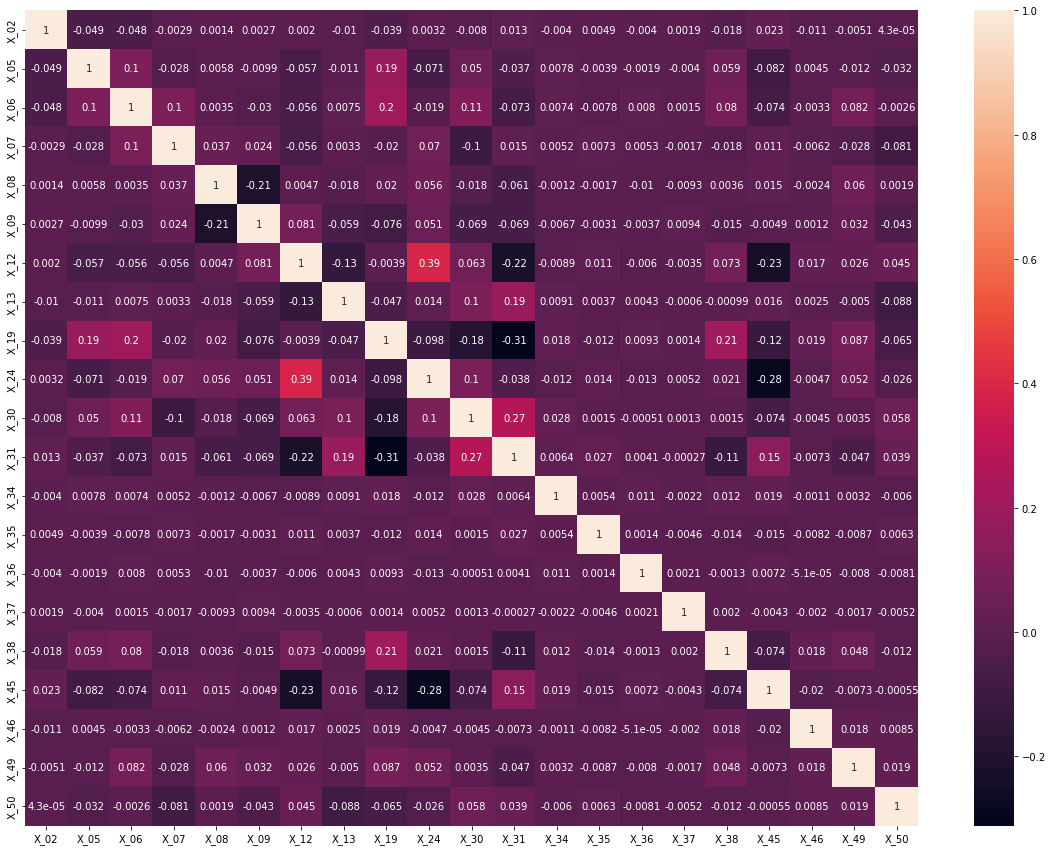

In [ ]:
plt.figure(figsize = (20,15))
sns.heatmap(X_train.corr(), annot = True)

## 남은 컬럼
- 02, 05, 06 // PCB 체결 시 단계별 누름량(Step 2,3,4)
- 07, 08, 09 // 방열 재료 x 면적(1,2,3)
- 12 // 커넥터 위치 기준 좌표
- 13 // 각 안테나 패드 위치(높이) 차이
- 19 // 1번 스크류 삽입 깊이
- 24 // 커넥터 1번 핀 치수
- 30, 31 // 스크류 삽입 깊이 x (1,2)
- 34, 35, 36, 37 // 스크류 체결 시 분당 회전수 x (1,2,3,4)
- 38 // 하우징 PCB 안착부 1 치수
- 45 // 안테나 부분 레이돔 기울기
- 46 // 실란트 본드 소요량
- 49 // Cal 투입 전 대기 시간
- 50 // RF1 부분 SMT 납 량

- 02, 05, 06의 단계별 누름량을 합했을 때 총 누름량을 구할 수 있음
- 30, 31도 위와 동일
- 34, 35, 36, 37도 같은 부품이라면 동일한 회전수가 나올 것으로 예상됨

In [ ]:
X_train["sum_pressed"] = X_train["X_02"] + X_train["X_05"] + X_train["X_06"]
test_x["sum_pressed"] = test_x["X_02"] + test_x["X_05"] + test_x["X_06"]

In [ ]:
X_train["screw_depth"] = X_train["X_30"] + X_train["X_31"]
test_x["screw_depth"] = test_x["X_30"] + test_x["X_31"]

In [ ]:
X_train["screwed_per_min"] = X_train["X_34"] + X_train["X_35"] + X_train["X_36"] + X_train["X_37"]
test_x["screwed_per_min"] = test_x["X_34"] + test_x["X_35"] + test_x["X_36"] + test_x["X_37"]

In [ ]:
X_train.drop(["X_02", "X_05", "X_06", "X_30", "X_31", "X_34", "X_35", "X_36", "X_37"], axis = 1, inplace = True)
test_x.drop(["X_02", "X_05", "X_06", "X_30", "X_31", "X_34", "X_35", "X_36", "X_37"], axis = 1, inplace = True)

In [ ]:
X_train.head()

,X_07,X_08,X_09,X_12,X_13,X_19,X_24,X_38,X_45,X_46,X_49,X_50,sum_pressed,screw_depth,screwed_per_min
0,3.416086,4.149148,245.71,4.34,0.18,3.11,2.05,-16.41,0.29,7.288928,9.180606,137.043591,84.264143,1.901824,51.75
1,3.392157,4.130837,233.61,4.38,0.18,2.97,2.10,-16.06,0.13,7.288928,9.251907,133.736691,82.224658,1.894361,51.61
2,3.394844,4.670677,272.20,4.36,0.15,3.04,2.07,-16.16,0.14,7.292337,9.301052,132.805112,82.236324,1.901824,51.71
3,3.398527,4.755399,255.36,4.33,0.21,3.05,2.06,-16.05,0.22,7.293018,9.616341,134.138760,86.303910,1.890035,51.79
4,3.423611,4.648038,241.46,4.35,0.16,3.04,2.09,-16.25,0.22,7.293018,9.310369,142.728970,80.186008,1.898100,51.68


In [ ]:
test_x.head()

,X_07,X_08,X_09,X_12,X_13,X_19,X_24,X_38,X_45,X_46,X_49,X_50,sum_pressed,screw_depth,screwed_per_min
0,3.450305,4.167750,239.80,4.37,0.15,3.27,2.22,-16.17,0.16,7.293018,9.754328,138.130429,83.243910,1.795320,51.76
1,3.368330,4.770600,189.23,4.36,0.17,3.26,2.11,-15.35,0.27,7.288244,9.748909,136.148839,77.127114,1.798669,51.71
2,3.422633,5.331172,214.93,4.43,0.20,3.07,2.13,-16.27,0.14,7.293018,9.606551,120.447446,86.303065,1.905832,51.86
3,3.372455,4.648038,180.80,4.39,0.18,3.23,2.10,-16.06,0.13,7.293018,9.632566,133.994695,83.243890,1.886842,51.84
4,3.431403,4.279440,231.93,4.38,0.12,3.17,2.12,-16.06,0.09,7.293018,9.282961,137.918202,84.264143,1.912560,51.85


- 07,08,09 방열 재료 면적은 합이나 평균을 통해서 묶을 수도 있지만 각 공정별 미치는 영향이 다를 것으로 판단되어 그대로 놔둠

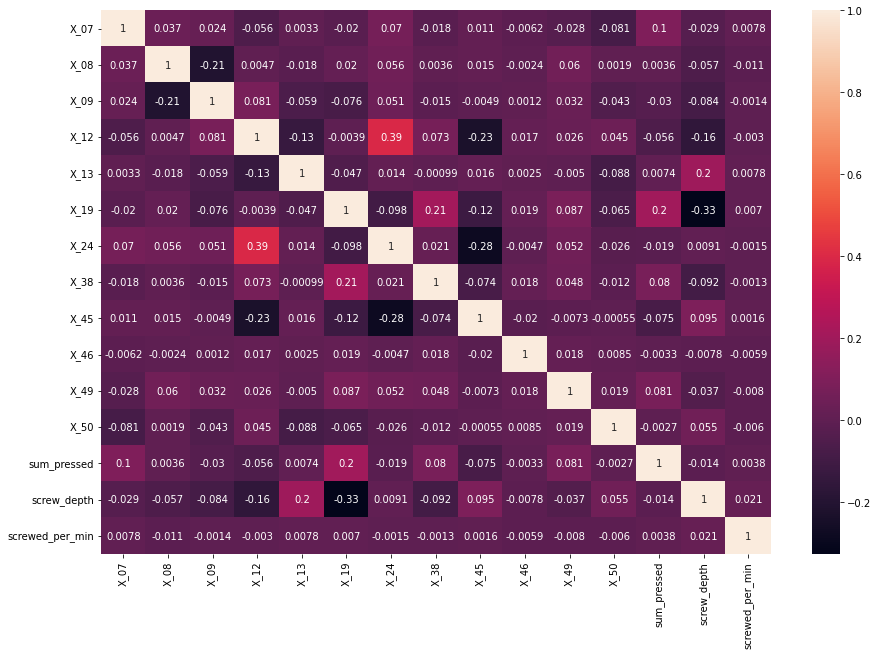

In [ ]:
fig = plt.figure(figsize = (15,10))
sns.heatmap(X_train.corr(), annot = True)

# 모델링 + 훈련

In [ ]:
! pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
from lightgbm import LGBMRegressor as lgbm
lgbm_model = lgbm(n_estimators = 401, max_depth = 8)

from catboost import CatBoostRegressor as cat
cat_model = cat(n_estimators = 401, max_depth = 8)

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=401, max_depth=8, objective='reg:squarederror')

In [ ]:
LGBM = MultiOutputRegressor(lgbm_model).fit(X_train, Y_train)
preds1 = LGBM.predict(test_x)

In [ ]:
CAT = MultiOutputRegressor(cat_model).fit(X_train, Y_train)
preds2 = CAT.predict(test_x)

In [ ]:
RF = RandomForestRegressor(n_estimators = 401, max_depth = 8).fit(X_train, Y_train)
preds3 = RF.predict(test_x)

In [ ]:
XGB = MultiOutputRegressor(xgb_model).fit(X_train, Y_train)
preds4 = XGB.predict(test_x)

In [ ]:
LR = MultiOutputRegressor(LinearRegression()).fit(X_train, Y_train)
preds5 = LR.predict(test_x)

In [ ]:
all_pred = (preds1 + preds2 + preds3 + preds4 + preds5) / 5

# 제출

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon/lg_antena/sample_submission.csv')

In [ ]:
for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = all_pred[:,idx-1]

In [ ]:
submit.to_csv('/all_model_submit.csv', index=False)

In [ ]:
submit.head(5)

,ID,Y_01,Y_02,Y_03,Y_04,Y_05,Y_06,Y_07,Y_08,Y_09,Y_10,Y_11,Y_12,Y_13,Y_14
0,TEST_00001,1.400924,1.181878,1.023595,14.683326,31.845061,16.686143,2.988094,-26.056967,-26.184509,-22.111639,24.449564,-26.005552,-26.032731,-26.053130
1,TEST_00002,1.462042,1.176286,1.125337,13.590725,30.954609,16.664237,3.213220,-26.236696,-26.100458,-22.210876,24.325609,-25.998863,-26.078453,-26.058666
2,TEST_00003,1.461802,1.160893,1.117348,14.666121,31.735745,16.727842,3.096505,-26.102267,-26.200829,-22.187443,24.736253,-25.956519,-26.105336,-26.099887
3,TEST_00004,1.368045,1.113381,0.976065,14.894739,31.917626,17.052604,3.114424,-25.785465,-25.702481,-21.921603,24.855248,-25.668616,-25.715676,-25.675992
4,TEST_00005,1.409042,1.007619,1.064792,14.663766,31.157561,16.946877,3.128592,-25.978704,-26.008470,-22.213300,24.429859,-25.936305,-25.766770,-25.889114


# 가설과의 비교
- 상관관계를 분석했을 때 비슷한 공정의 경우 대체적으로 높은 상관관계를 보이는 것을 확인하였습니다.(일부는 전혀 상관관계를 가지지 않는 모습을 보입니다.)

# 확인하지 못한 점
- 맨 처음 공정이 예측에 가장 많은 영향을 끼칠 것으로 예상하였으나, 이를 어떻게 검증해야할지 찾지 못하였습니다.
- 변수 X_00 을 제거할 때 처음이 아닌 다른 변수들을 제거한다면 처음 공정이 가장 중요한지에 대해 비교할 가능성이 있으나, 이 방법으로 검증을 할 수 있는지에 대해서는 의문을 가지고 있습니다.

# 회고
- 상위권 분들의 코드가 올라오지 않아서 어떤 방식으로 분석을 하고 전처리를 했는지 궁금합니다
- 변수를 드랍하기 전 미리 피쳐엔지니어링을 했어야 했는데, 드랍하고 남은 값들만 피쳐엔지니어링을 해서 점수가 낮았던 것이 아닐까 하고 추측하고 있습니다.
- 음수에 log 변환을 했을 때 결측치가 된다는 것을 처음 알았습니다.
- 처음으로 혼자 참여한 competition 이어서 어떻게 해야할 지 많이 헤맸었는데 다음에는 헤매지 않고 할 수 있을 것 같습니다.